C:\Users\alici\AppData\Local\Temp\ipykernel_7692\2971096611.py:35: RuntimeWarning: overflow encountered in cosh
  sech2   = 1/np.cosh(kh)**2
C:\Users\alici\AppData\Local\Temp\ipykernel_7692\2971096611.py:38: RuntimeWarning: overflow encountered in divide
  step = f/np.maximum(df,1e-16)
C:\Users\alici\AppData\Local\Temp\ipykernel_7692\2971096611.py:37: RuntimeWarning: invalid value encountered in multiply
  df = g*tanh_kh + g*k*h*sech2



Comparación R26:
      x_m  H_obs_m  H_TG83_m  H_hibrido_m
0  23.45    0.303     0.298        0.298
1  45.45    0.294     0.294        0.294
2  52.70    0.289     0.275        0.275
3  60.20    0.226     0.220        0.220
4  70.95    0.254     0.202        0.242
5  81.95    0.232     0.166        0.226

Comparación R27:
      x_m  H_obs_m  H_TG83_m  H_hibrido_m
0  23.45    0.328     0.337        0.337
1  45.45    0.322     0.329        0.329
2  52.70    0.290     0.298        0.298
3  60.20    0.231     0.228        0.228
4  70.95    0.244     0.205        0.248
5  81.95    0.216     0.160        0.226


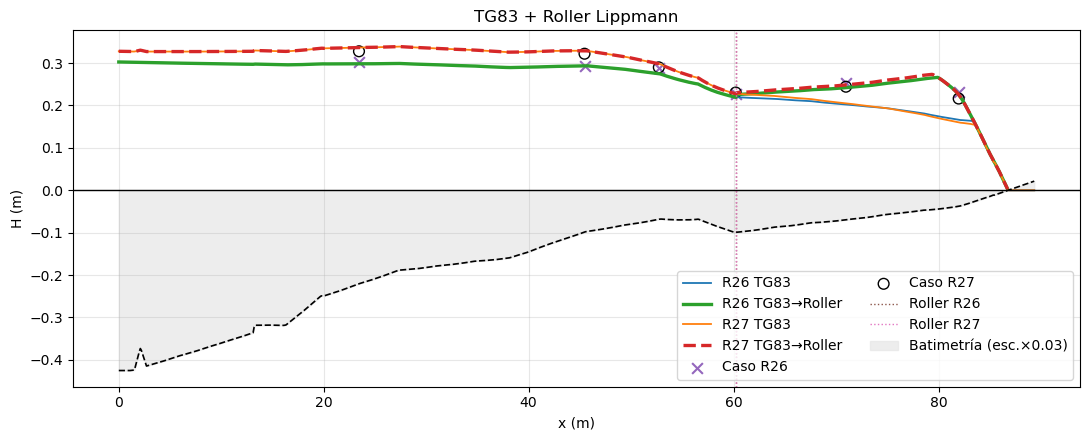

In [107]:


import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt

# Datos de entrada, puntos de del experimento y batimetria
path_R26  = 'R26.mat'
path_R27  = 'R27.mat'
path_bathy= 'REU2004bathy.txt'

mat_R26 = sio.loadmat(path_R26)['R26']
mat_R27 = sio.loadmat(path_R27)['R27']

#transformacion de campos desde MATLAB
def get_array(struct, field):
    return np.array(struct[field][0,0]).squeeze()

xg_R26 = get_array(mat_R26, 'xreal').astype(float).flatten()
xg_R27 = get_array(mat_R27, 'xreal').astype(float).flatten()
H_R26  = get_array(mat_R26['LWF'][0,0], 'H').astype(float).flatten()
H_R27  = get_array(mat_R27['LWF'][0,0], 'H').astype(float).flatten()

bathy = np.loadtxt(path_bathy, comments='%')
x_b, z_b = bathy[:,0].astype(float), bathy[:,1].astype(float)

# Calculo de dispercion lineal con  ω²=gk tanh(kh) por Newton-Raphson
g, rho = 9.81, 1025.0

def wavenumber(omega, h, tol=1e-12, itmax=60):
    h = np.asarray(h, dtype=float)
    k = np.sqrt(omega**2/g) * np.ones_like(h)
    for _ in range(itmax):
        kh = k*h
        tanh_kh = np.tanh(kh)
        sech2   = 1/np.cosh(kh)**2
        f  = g*k*tanh_kh - omega**2
        df = g*tanh_kh + g*k*h*sech2
        step = f/np.maximum(df,1e-16)
        k_new = k - step
        if np.max(np.abs(step)) < tol:
            k = k_new; break
        k = k_new
    return np.maximum(k,1e-12)

#Calculo de velocidad de fase C=w/k y valocidad de grupo Cg = nC 

def group_velocity(omega, k, h):
    n = 0.5*(1 + (2*k*h)/np.sinh(2*k*h))
    C = omega/np.maximum(k,1e-12)
    return n*C, C


# Suavizadores
def smooth(y, n=9):
    n = max(3, int(n)|1)
    r = (n-1)//2
    ypad = np.r_[y[0]*np.ones(r), y, y[-1]*np.ones(r)]
    return np.convolve(ypad, np.ones(n)/n, mode='valid')

def slope(x,z):
    return np.maximum(-np.gradient(z,x), 1e-6)

# Malla rectangular de Δx≈0.1 m y periodos segun experimento CaHa08
x_min = min(x_b.min(), xg_R26.min(), xg_R27.min())
x_max = max(x_b.max(), xg_R26.max(), xg_R27.max())
x = np.arange(x_min, x_max+1e-9, 0.1)
z = np.interp(x, x_b, z_b)     # negativo (fondo)
h = -z

T_R26, T_R27 = 4.0, 5.0
w_R26, w_R27 = 2*np.pi/T_R26, 2*np.pi/T_R27

# Se calculo rotura con dispercion segun TG83, se calcula Hrms realizando balance de energia Ew=1/8*ρgHrms^2, 
# y balance de energia d/dx(Ew*Cg)=−εb
def tg83_forward(x, h, Hrms0, omega, B, gamma=0.42):
    Hrms = np.zeros_like(h)
    Hrms[0] = Hrms0
    for i in range(len(h)-1):
        hi, hip1 = max(h[i],1e-3), max(h[i+1],1e-3)
        ki = wavenumber(omega, hi); Cgi,_ = group_velocity(omega, ki, hi)
        Ei = 0.125*rho*g*Hrms[i]**2
        L  = 2*np.pi/ki
        Cb = 0.25
        eps_b = Cb * rho * g * (B*Hrms[i])**3 / (L * hi)
        dx = x[i+1]-x[i]
        Flux_i   = Ei*Cgi
        Flux_ip1 = max(Flux_i - eps_b*dx, 1e-12)
        kip1 = wavenumber(omega, hip1); Cg_ip1,_ = group_velocity(omega, kip1, hip1)
        Ei_ip1 = Flux_ip1 / Cg_ip1
        Hrms_ip1 = np.sqrt(max(Ei_ip1,1e-12)/(0.125*rho*g))
        Hrms[i+1] = min(Hrms_ip1, gamma*hip1)
    return Hrms

# Frontera 
def infer_Hrms0_from_gauge(x, z, xg1, H1, omega):
    h1 = -np.interp(xg1, x, z)
    k1 = wavenumber(omega, h1); Cg1,_ = group_velocity(omega, k1, h1)
    E1 = 0.0625*rho*g*H1**2
    F  = E1*Cg1
    h0 = -z[0]; k0 = wavenumber(omega, h0); Cg0,_ = group_velocity(omega, k0, h0)
    E0 = F/np.maximum(Cg0,1e-6)
    return np.sqrt(E0/(0.125*rho*g))

# Se calcula roller con paper de Lippman et al (1996)
def roller_from_i0(x, z, i0, Hobs_i0, omega,
                   gamma=0.60, alpha_r=1.00,
                   smooth_n=9, s_min=1e-3, frac_max=0.25):
    
    #Aplica roller SOLO para i>=i0; condición en i0: H=Hobs_i0, ER=0.
    
    z_s = smooth(z, n=smooth_n); h_s = -z_s; s = slope(x, z_s)
    nx = len(x)
    Hrms = np.zeros(nx); ER = np.zeros(nx); Sb = np.zeros(nx); Dr = np.zeros(nx)

    Hrms[i0] = Hobs_i0/np.sqrt(2.0)
    k_all = wavenumber(omega, h_s)
    Cg_i0,_ = group_velocity(omega, k_all[i0], h_s[i0])
    E_i0 = 0.125*rho*g*Hrms[i0]**2
    Fw   = E_i0 * Cg_i0
    Rc   = 0.0

    for i in range(i0, nx-1):
        hi, hip1 = max(h_s[i],1e-4), max(h_s[i+1],1e-4)
        Cgip1,_  = group_velocity(omega, k_all[i+1], hip1)
        dx = x[i+1]-x[i]
        # H_shoal en i+1
        Ew_shoal = max(Fw,1e-12)/max(Cgip1,1e-6)
        Hshoal   = np.sqrt(Ew_shoal/(0.125*rho*g))*np.sqrt(2.0)
        H_lim    = gamma*hip1
        if Hshoal > H_lim:
            Ew_lim = 0.125*rho*g*((H_lim/np.sqrt(2.0))**2)
            Fw_lim = Ew_lim*Cgip1
            f_break = np.exp(-(H_lim/np.maximum(Hshoal,1e-9))**2)
            S_raw   = f_break*(Fw - Fw_lim)/max(dx,1e-6)
            S       = min(S_raw, 0.25*Fw/max(dx,1e-6))   # limitador
        else:
            S = 0.0
        # Flujos
        Fw_next = max(Fw - S*dx, 1e-12)
        Lr = alpha_r * hi / max(s[i], s_min)
        Dr_i = Rc / max(Lr, 1e-3)
        Rc_next = max(Rc + (S - Dr_i)*dx, 0.0)
        # Ola en i+1
        Ew_ip1 = Fw_next / max(Cgip1,1e-6)
        Hr_ip1 = np.sqrt(Ew_ip1/(0.125*rho*g))
        Hr_ip1 = min(Hr_ip1, (gamma*hip1)/np.sqrt(2.0))
        Hrms[i+1] = Hr_ip1
        ER[i+1]   = Rc_next / max(omega/k_all[i+1], 1e-6)
        Sb[i], Dr[i] = S, Dr_i
        Fw, Rc = Fw_next, Rc_next

    return Hrms, ER, Sb, Dr

# Se combinan ambos modelos, ddisipacion lineal y con roller 
def run_case_TG83_then_Roller(xg, Hobs, omega, B_tg83, gamma_tg83=0.42,
                              gamma_roller=0.60, alpha_r=1.00):
    """
    1) TG83 en todo el dominio.
    2) i0 = 4º gauge. Mantener TG83 para x <= x[i0].
    3) Roller desde i0 con H = Hobs[3] en i0; REEMPLAZAR solo x > x[i0].
    """
    # TG83 (condición: H_obs[0])
    Hrms0 = float(Hobs[0])/np.sqrt(2.0)
    Hrms_tg83 = tg83_forward(x, h, Hrms0, omega, B_tg83, gamma=gamma_tg83)

    # Indice del 4º gauge y roller desde ahí
    x_break = float(xg[3])
    i0 = int(np.argmin(np.abs(x - x_break)))
    Hr_tail, ER, Sb, Dr = roller_from_i0(x, z, i0, float(Hobs[3]), omega,
                                         gamma=gamma_roller, alpha_r=alpha_r)

    # Ensamble: TG83 hasta el 4º (incluido), roller DESPUÉS del 4º
    Hrms_hybrid = Hrms_tg83.copy()
    Hrms_hybrid[i0+1:] = Hr_tail[i0+1:]  # ojo: i0 queda TG83

    # Comparación en puntos
    H_tg83   = np.interp(xg, x, Hrms_tg83)*np.sqrt(2.0)
    H_hybrid = np.interp(xg, x, Hrms_hybrid)*np.sqrt(2.0)
    comp = pd.DataFrame({
        'x_m': xg,
        'H_obs_m': Hobs,
        'H_TG83_m': H_tg83,
        'H_hibrido_m': H_hybrid
    })
    diag = dict(Hrms_tg83=Hrms_tg83, Hrms_hybrid=Hrms_hybrid,
                i0=i0, x_break=x_break, ER=ER, Sb=Sb, Dr=Dr)
    return comp, diag

# Se aplican funciones para caso R26 y R27 con un B 1.3 y 1.5 respectivamente gamma roller 0.6 y alpha 1 y 1.05 por mejor ajuste 
B_R26, B_R27 = 1.3, 1.5
params_R26 = dict(gamma_tg83=0.42, gamma_roller=0.60, alpha_r=1.00)
params_R27 = dict(gamma_tg83=0.42, gamma_roller=0.60, alpha_r=1.05)

comp26, diag26 = run_case_TG83_then_Roller(xg_R26, H_R26, w_R26, B_R26, **params_R26)
comp27, diag27 = run_case_TG83_then_Roller(xg_R27, H_R27, w_R27, B_R27, **params_R27)

print("\nComparación R26:\n", comp26.round(3))
print("\nComparación R27:\n", comp27.round(3))

# Graifcos

Hmax = max(H26_tg83.max(), H26_hybrid.max(),
           H27_tg83.max(), H27_hybrid.max(),
           H_R26.max(), H_R27.max())

# Escalar batimetria para que se vea bien :)
zb_scaled = z_b * 0.1   # sigue siendo negativo → queda bajo la línea H=0

plt.figure(figsize=(11,4.5))

# Modelos R26
plt.plot(x, H26_tg83,   color='C0', lw=1.3, label='R26 TG83')
plt.plot(x, H26_hybrid, color='C2', lw=2.4, label='R26 TG83→Roller')

# Modelos R27
plt.plot(x, H27_tg83,   color='C1', lw=1.3, label='R27 TG83')
plt.plot(x, H27_hybrid, color='C3', lw=2.4, ls='--', label='R27 TG83→Roller')

# Puntos experimentales
plt.scatter(xg_R26, H_R26, marker='x', s=60, color='C4', label='Caso R26')
plt.scatter(xg_R27, H_R27, facecolors='none', edgecolors='k', s=60, label='Caso R27')

# Líneas dondecomienza a correr el roller
plt.axvline(diag26['x_break'], color='C5', ls=':', lw=1, label='Roller R26')
plt.axvline(diag27['x_break'], color='C6', ls=':', lw=1, label='Roller R27')

# Batimetría (misma figura, bajo H=0)
plt.fill_between(x_b, zb_scaled, 0, color='0.9', alpha=0.7,
                 label=f'Batimetría (esc.×{scale:.2f})')
plt.plot(x_b, zb_scaled, 'k--', lw=1.2)

# Ejes y estilo
plt.axhline(0, color='k', lw=1)  # referencia H=0
plt.title('TG83 + Roller Lippmann')
plt.xlabel('x (m)'); plt.ylabel('H (m)')
plt.grid(alpha=0.3)
plt.legend(ncol=2, loc='best')
plt.tight_layout()
plt.show()






